In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, f1_score
import statsmodels.api as sm
from prophet import Prophet
import xgboost as xgb


In [2]:
# Loading dataset
df = pd.read_csv('/content/Bakery sales.csv')

# shape and first few rows of the data
print("Shape of the loaded DataFrame:", df.shape)
print("First few rows of the loaded DataFrame:")
print(df.head())


Shape of the loaded DataFrame: (233999, 6)
First few rows of the loaded DataFrame:
         date   time  ticket_number               article  Quantity unit_price
0  02-01-2021  08:38         150040              BAGUETTE         1      0,90 
1  02-01-2021  08:38         150040      PAIN AU CHOCOLAT         3      1,20 
2  02-01-2021  09:14         150041      PAIN AU CHOCOLAT         2      1,20 
3  02-01-2021  09:14         150041                  PAIN         1      1,15 
4  02-01-2021  09:25         150042  TRADITIONAL BAGUETTE         5      1,20 


In [3]:
# first few rows of the dataset
df.head()

# basic structure and missing data
df.info()

# Summary Stats
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233999 entries, 0 to 233998
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   date           233999 non-null  object
 1   time           233999 non-null  object
 2   ticket_number  233999 non-null  int64 
 3   article        233999 non-null  object
 4   Quantity       233999 non-null  int64 
 5   unit_price     233999 non-null  object
dtypes: int64(2), object(4)
memory usage: 10.7+ MB


,ticket_number,Quantity
count,233999.000000,233999.000000
mean,219202.339048,1.557195
std,40053.027334,1.266838
min,150040.000000,1.000000
25%,184756.000000,1.000000
50%,218808.000000,1.000000
75%,253928.500000,2.000000
max,288913.000000,200.000000


#Data Cleaning and Transformation


In [4]:
# Read the CSV file into a DataFrame
df = pd.read_csv('/content/Bakery sales.csv')

# shape and first few rows of the loaded dataframe
print("Shape of the loaded DataFrame:", df.shape)
print("First few rows of the loaded DataFrame:")
print(df.head())

# 1. Convert 'unit_price' from string (with commas) to float
df['unit_price'] = df['unit_price'].astype(str).str.replace(',', '.').astype(float)

# 2. Convert 'date' to datetime format (DD-MM-YYYY)
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y', errors='coerce')

# 3. Convert 'time' from string (HH:MM) to datetime object and extract time (HH:MM)
df['time'] = pd.to_datetime(df['time'], format='%H:%M', errors='coerce').dt.strftime('%H:%M')

# 4. Extract additional features from 'time' (hour)
df['hour'] = pd.to_datetime(df['time'], format='%H:%M').dt.hour

# 5. Extract 'day_of_week' from 'date' (0 = Monday, 6 = Sunday)
df['day_of_week'] = df['date'].dt.dayofweek

# 6. Extract 'month' from 'date'
df['month'] = df['date'].dt.month

# Check to confirm changes
print("First few rows after cleaning:")
print(df.head())

# Check the data types of columns to confirm the changes
print("\nData types of the cleaned DataFrame:")
print(df.dtypes)


Shape of the loaded DataFrame: (233999, 6)
First few rows of the loaded DataFrame:
         date   time  ticket_number               article  Quantity unit_price
0  02-01-2021  08:38         150040              BAGUETTE         1      0,90 
1  02-01-2021  08:38         150040      PAIN AU CHOCOLAT         3      1,20 
2  02-01-2021  09:14         150041      PAIN AU CHOCOLAT         2      1,20 
3  02-01-2021  09:14         150041                  PAIN         1      1,15 
4  02-01-2021  09:25         150042  TRADITIONAL BAGUETTE         5      1,20 
First few rows after cleaning:
        date   time  ticket_number               article  Quantity  \
0 2021-01-02  08:38         150040              BAGUETTE         1   
1 2021-01-02  08:38         150040      PAIN AU CHOCOLAT         3   
2 2021-01-02  09:14         150041      PAIN AU CHOCOLAT         2   
3 2021-01-02  09:14         150041                  PAIN         1   
4 2021-01-02  09:25         150042  TRADITIONAL BAGUETTE      

In [5]:
# Check for missing values in the DataFrame
missing_values = df.isnull().sum()

# Print the missing values
print("Missing values in each column:")
print(missing_values)


Missing values in each column:
date             0
time             0
ticket_number    0
article          0
Quantity         0
unit_price       0
hour             0
day_of_week      0
month            0
dtype: int64


#Data Aggeregation

In [6]:
# Creating 'total_price' column for each line item
df['total_price'] = df['Quantity'] * df['unit_price']

# Grouping data by 'ticket_number' to find total value and total items per transaction
transaction_summary = df.groupby('ticket_number').agg(
    total_items=('Quantity', 'sum'),
    total_value=('total_price', 'sum')
).reset_index()

# First few rows of the transaction summary
print(transaction_summary.head())


   ticket_number  total_items  total_value
0         150040            4         4.50
1         150041            3         3.55
2         150042            5         6.00
3         150043            5         5.10
4         150044            1         1.05


Exploratory Data Analysis

In [7]:
# most popular items
popular_items = df.groupby('article')['Quantity'].sum().sort_values(ascending=False).head(10)
print("Top 10 most popular items:")
print(popular_items)

# total sales by day of the week
sales_by_day = df.groupby('day_of_week')['total_price'].sum()
print("Sales by day of the week:")
print(sales_by_day)

# sales by month
sales_by_month = df.groupby('month')['total_price'].sum()
print("Sales by month:")
print(sales_by_month)


Top 10 most popular items:
article
TRADITIONAL BAGUETTE    118723
CROISSANT                29990
PAIN AU CHOCOLAT         25498
COUPE                    23697
BANETTE                  23008
BAGUETTE                 22259
CEREAL BAGUETTE           7529
SPECIAL BREAD             5520
FORMULE SANDWICH          5389
TARTELETTE                5082
Name: Quantity, dtype: int64
Sales by day of the week:
day_of_week
0     71141.55
1     64950.15
2     47816.20
3     67040.20
4     73637.60
5     90703.95
6    122513.25
Name: total_price, dtype: float64
Sales by month:
month
1     30061.25
2     33512.35
3     38545.60
4     48347.45
5     57424.95
6     48987.00
7     84544.50
8     97589.55
9     41815.95
10    21776.15
11    17301.25
12    17896.90
Name: total_price, dtype: float64


#ML Modeling

##Sales Forecasting with Prophet

In [8]:
!pip install prophet


In [9]:
# Importing libraries needed
from prophet import Prophet
import matplotlib.pyplot as plt

# getting our data into a shape that works for Prophet
# Prophet expects a specific format: a date column ('ds') and the value we want to forecast ('y')

# Aggregating daily sales data
# summing up the total sales ('total_price') for each day
daily_sales = df.groupby('date').agg({'total_price': 'sum'}).reset_index()

# Renaming columns to 'ds' and 'y' because Prophet requires this specific naming convention.
daily_sales.rename(columns={'date': 'ds', 'total_price': 'y'}, inplace=True)

# Quick check to make sure everything looks good.
print("Here's how our daily aggregated sales data looks:")
print(daily_sales.head())

Here's how our daily aggregated sales data looks:
          ds        y
0 2021-01-02   991.85
1 2021-01-03  1012.10
2 2021-01-04   459.90
3 2021-01-05   544.00
4 2021-01-07   525.00


In [11]:
# Generating the forecast.
# This step adds predictions ('yhat') and confidence intervals ('yhat_lower', 'yhat_upper') to the future DataFrame.
forecast = model.predict(future)

# last few rows of the forecasted data to get an idea of what the model thinks.
print("Here's a sneak peek at the forecasted values:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())



Here's a sneak peek at the forecasted values:
            ds         yhat   yhat_lower   yhat_upper
625 2022-10-26  1140.333157   694.236706  1579.772232
626 2022-10-27  1205.471401   720.463424  1622.421053
627 2022-10-28  1259.041304   847.789403  1683.447375
628 2022-10-29  1464.096132  1014.681826  1883.308524
629 2022-10-30  1806.296944  1352.773800  2235.882513


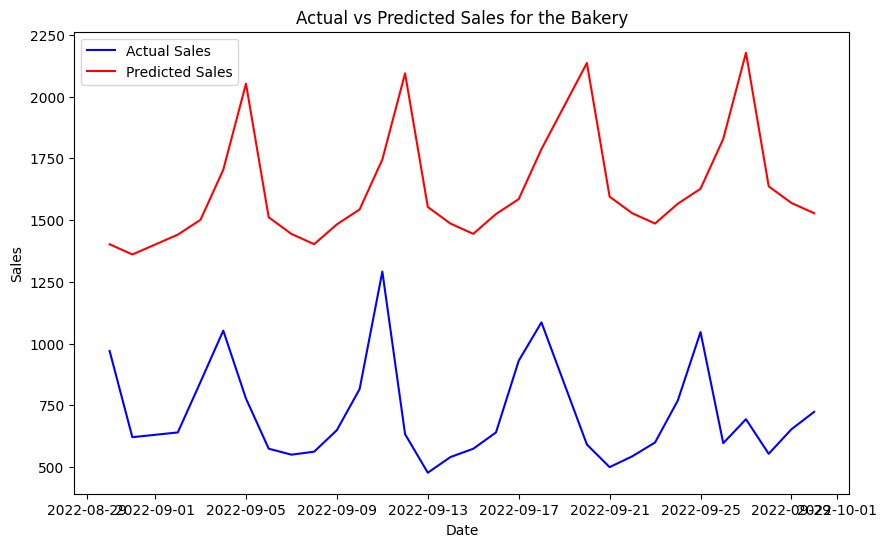

In [14]:
# Plotting actual vs predicted values for visual comparison
plt.figure(figsize=(10, 6))
plt.plot(test_data['ds'], test_data['y'], label='Actual Sales', color='blue')
plt.plot(test_data['ds'], forecast_test['yhat'][-30:], label='Predicted Sales', color='red')
plt.title("Actual vs Predicted Sales for the Bakery")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()


Better


In [15]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error

# Assuming your data is loaded into `daily_sales`
# daily_sales = pd.read_csv('your_data.csv')  # Make sure to load your data
# Let's ensure the 'ds' column is a datetime object
daily_sales['ds'] = pd.to_datetime(daily_sales['ds'])

# Define the holidays based on your provided list
holidays = pd.DataFrame({
    'holiday': ['New Year\'s Day', 'Good Friday', 'Easter Monday', 'Labour Day', 'Victory Day',
                'Ascension Day', 'Whit Monday', 'National Day', 'Assumption Day', 'All Saints\' Day',
                'Armistice Day', 'Christmas Day', 'Saint Stephen\'s Day'],
    'ds': pd.to_datetime([
        '2022-01-01', '2022-04-15', '2022-04-18', '2022-05-01', '2022-05-08',
        '2022-05-26', '2022-06-06', '2022-07-14', '2022-08-15', '2022-11-01',
        '2022-11-11', '2022-12-25', '2022-12-26'
    ]),
    'lower_window': 0,
    'upper_window': 1,
})

# Now define the model with holidays
model_with_holidays = Prophet(holidays=holidays)

# Add weekly seasonality (optional based on your data)
model_with_holidays.add_seasonality(name='weekly', period=7, fourier_order=3)

# Fit the model to the sales data
model_with_holidays.fit(daily_sales)

# Create future dataframe (e.g., forecast for the next 30 days)
future_with_holidays = model_with_holidays.make_future_dataframe(periods=30)

# Make predictions
forecast_with_holidays = model_with_holidays.predict(future_with_holidays)



INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbmv9s1j5/67dhlbls.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbmv9s1j5/_xy_p_55.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81113', 'data', 'file=/tmp/tmpbmv9s1j5/67dhlbls.json', 'init=/tmp/tmpbmv9s1j5/_xy_p_55.json', 'output', 'file=/tmp/tmpbmv9s1j5/prophet_modelkk0d2vy6/prophet_model-20241203162010.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:20:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:20:10 - cmdstanpy - INFO - Chain [1] do

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbmv9s1j5/nxglrbhj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbmv9s1j5/0e04n2f3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81662', 'data', 'file=/tmp/tmpbmv9s1j5/nxglrbhj.json', 'init=/tmp/tmpbmv9s1j5/0e04n2f3.json', 'output', 'file=/tmp/tmpbmv9s1j5/prophet_modelxixj7not/prophet_model-20241203162042.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:20:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:20:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


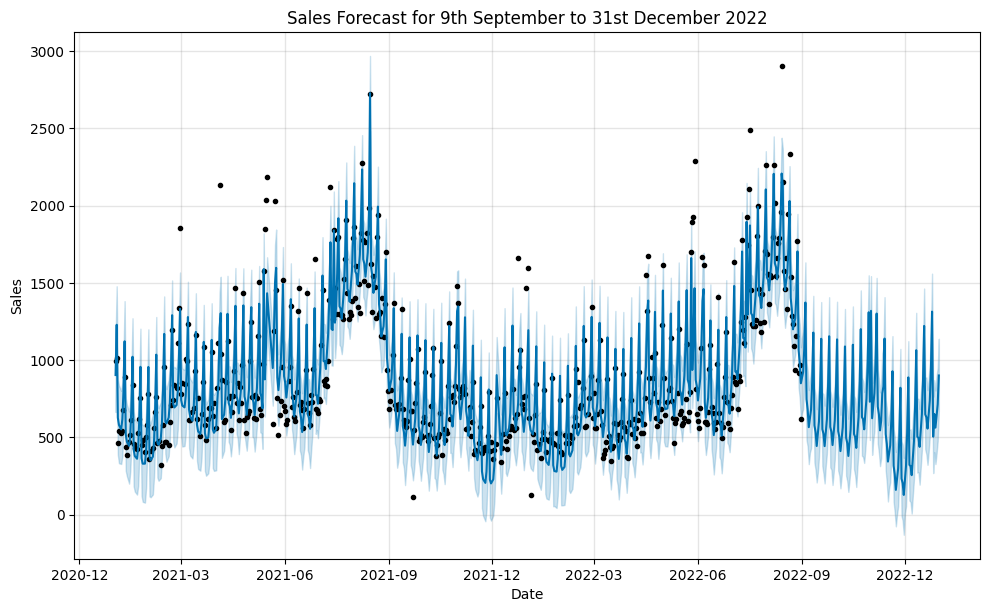

Mean Absolute Error (MAE): 90.86658419705226


In [18]:
# Initialize Prophet model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    holidays=holidays
)

#Fit the model on the training data
model.fit(train_data)

#Create a future dataframe for prediction
future = model.make_future_dataframe(periods=122)  # Predicting 9th September to 31st December 2022

#Predict future sales
forecast = model.predict(future)

#Visualize the forecast
fig = model.plot(forecast)
plt.title('Sales Forecast for 9th September to 31st December 2022')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

# Evaluate the model
# Compare forecast with actual data for September to December 2022
actual = test_data
forecast_for_test = forecast[forecast['ds'].isin(actual['ds'])]
mae = mean_absolute_error(actual['y'], forecast_for_test['yhat'])
print(f"Mean Absolute Error (MAE): {mae}")

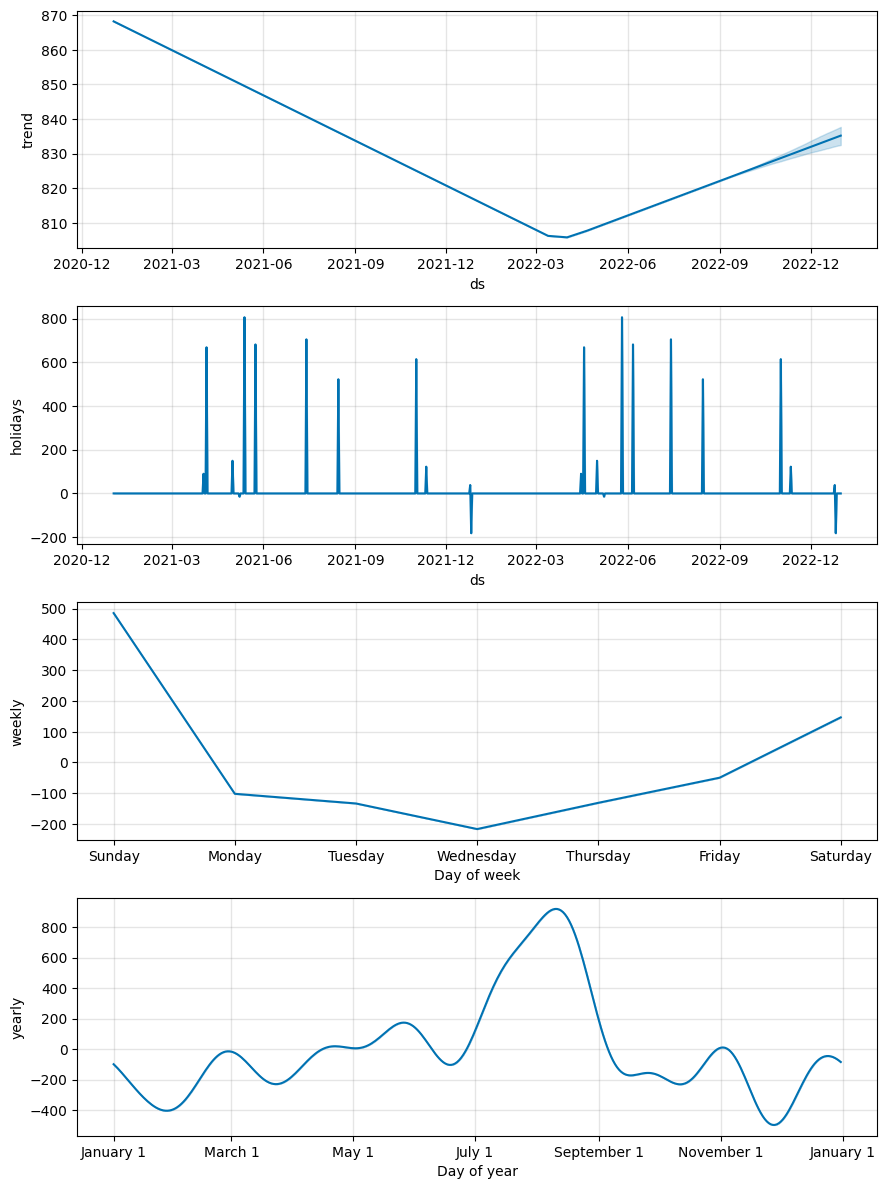

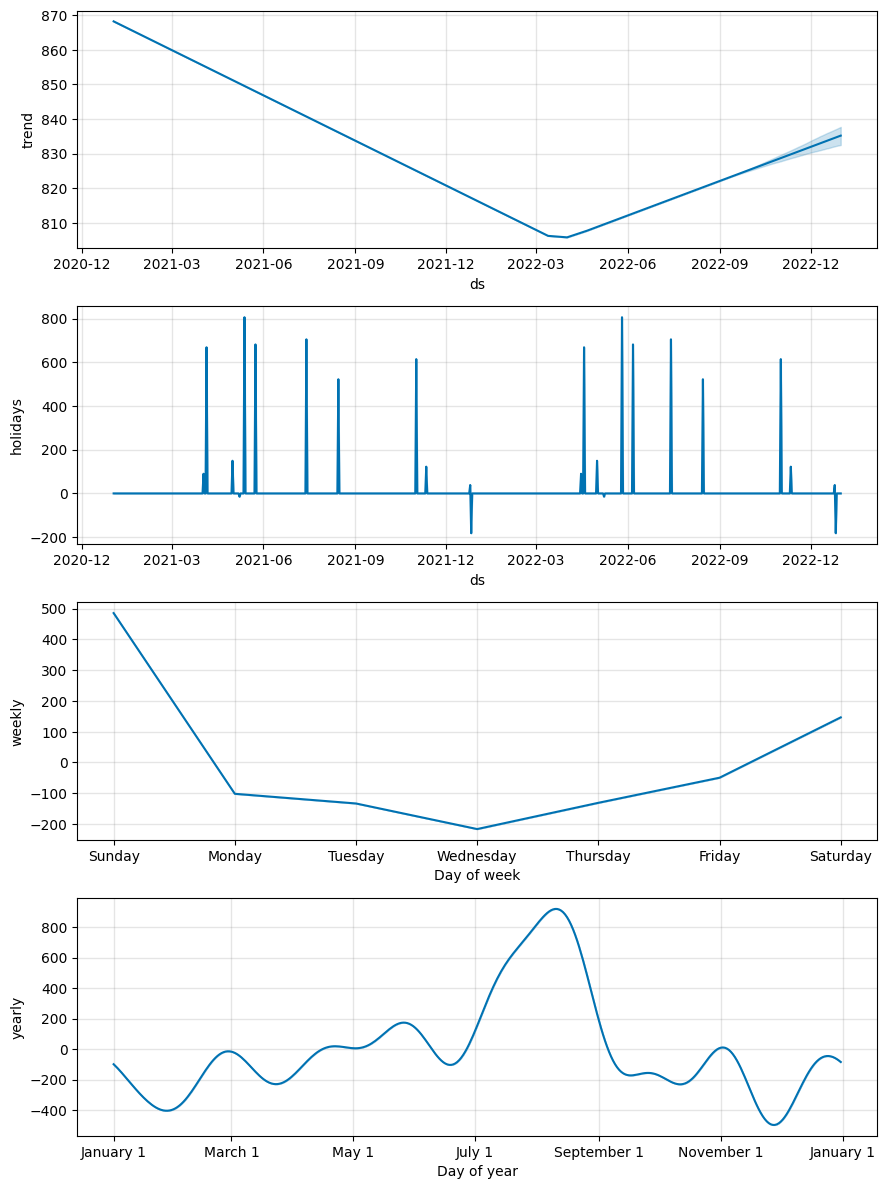

In [ ]:
model.plot_components(forecast)

## Analyze Weekday vs. Weekend Trends

  day_type  total_sales  average_sales
0  Weekday     324585.7       2.225263
1  Weekend     213217.2       2.419211


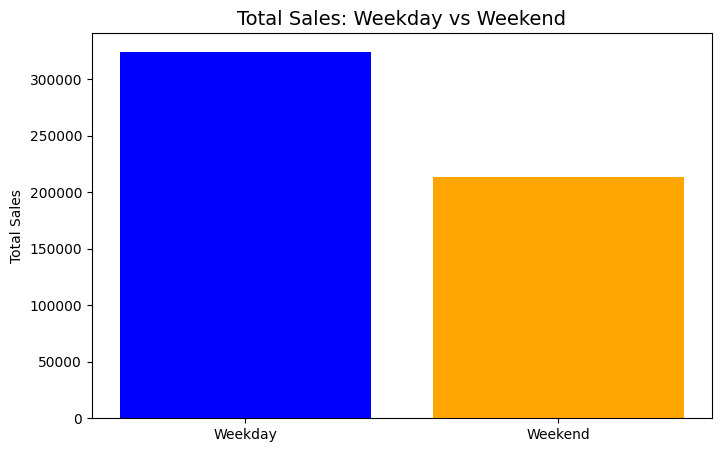

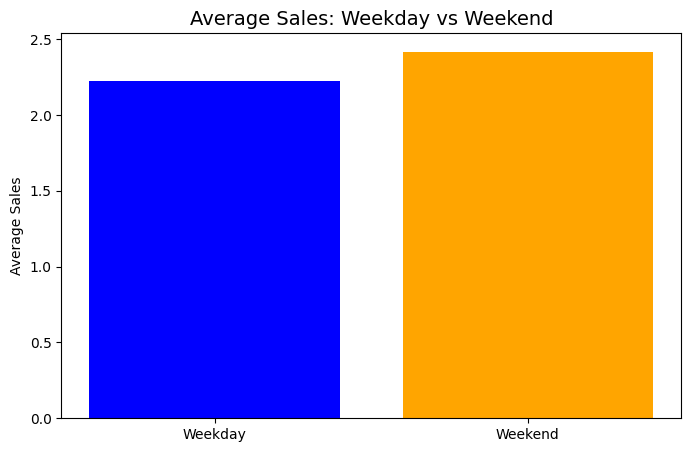

In [19]:
# Convert 'date' column to datetime if not already
df['date'] = pd.to_datetime(df['date'])

# Add a 'day_of_week' column if not already present (0=Monday, 6=Sunday)
df['day_of_week'] = df['date'].dt.dayofweek

# Categorize days into 'Weekday' and 'Weekend'
df['day_type'] = df['day_of_week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Aggregate sales data by 'day_type'
weekday_vs_weekend_sales = df.groupby('day_type').agg(
    total_sales=('total_price', 'sum'),
    average_sales=('total_price', 'mean')
).reset_index()

print(weekday_vs_weekend_sales)

# Visualize the sales data
import matplotlib.pyplot as plt

# Bar plot for total sales
plt.figure(figsize=(8, 5))
plt.bar(weekday_vs_weekend_sales['day_type'], weekday_vs_weekend_sales['total_sales'], color=['blue', 'orange'])
plt.title('Total Sales: Weekday vs Weekend', fontsize=14)
plt.ylabel('Total Sales')
plt.show()

# Bar plot for average sales
plt.figure(figsize=(8, 5))
plt.bar(weekday_vs_weekend_sales['day_type'], weekday_vs_weekend_sales['average_sales'], color=['blue', 'orange'])
plt.title('Average Sales: Weekday vs Weekend', fontsize=14)
plt.ylabel('Average Sales')
plt.show()


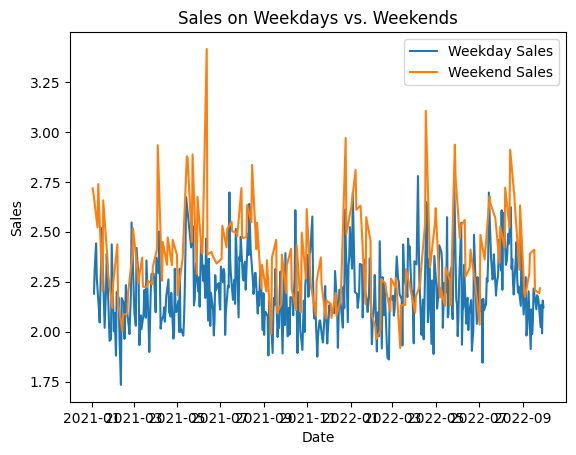

In [20]:
# Group data by 'day_of_week' to calculate the average sales for weekdays and weekends
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

weekday_sales = df[df['is_weekend'] == 0].groupby('date')['total_price'].mean()
weekend_sales = df[df['is_weekend'] == 1].groupby('date')['total_price'].mean()

# Visualize the difference
plt.plot(weekday_sales.index, weekday_sales, label='Weekday Sales')
plt.plot(weekend_sales.index, weekend_sales, label='Weekend Sales')
plt.legend()
plt.title('Sales on Weekdays vs. Weekends')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()
